In [ ]:

import os
os.environ["CUDA_VISIBLE_DEVICES"] = "-1" 
import tensorflow as tf
print(tf.__version__)
from tensorflow import keras
import time
import os
import json
import importlib
from matplotlib import pyplot as plt
import preprocess
# import preprocess as prep
# import SLR_model
# import SLR_model_GRU
import SLR_model_CL_GRU
import numpy as np
# from preprocess import person



# model will output multiple(5) results/sec, how are we gonna handle it?


2.17.0


In [ ]:
load_size = 3000 # number of data to be loaded at once
epochs = 30
run_time=3
batch_size = 16
save_dir = "saves_GRU"
load_dir = "saves_GRU"
model = SLR_model_GRU.get_model()

In [ ]:
# hand input shape: (batch, time, h, w, channels)
# pose input shape: (batch, time, channel, features)

In [ ]:
# PER VIDEO TRAINING LOOP

end_file=preprocess.getoutputdir()

save_suffix = time.strftime("%m-%d-%H", time.localtime(time.time()))
ckpt_name=save_suffix+"-"+str(epochs)+"epochs-"+str(run_time)+"times"

check_path = os.path.join(save_dir,'ckpt',ckpt_name)
hist_path = os.path.join(save_dir, "hist",ckpt_name+".json")

model_checkpoint_callback = keras.callbacks.ModelCheckpoint(
filepath=f'{check_path}.keras',
monitor='categorical_accuracy',
mode='max',
save_freq='epoch',
save_best_only=True)


start_person=1

for i in range(1,17):
    if start_person>i:
        continue
    for k in range(1,run_time+1):
        chkpt_elapsed = 0
        file_list = sorted(os.listdir(os.path.join(preprocess.getoutputdir(),str(i))))
        for j in file_list: # every video
            l_raw, r_raw, p_raw, y_raw, loss_weights_raw = preprocess.load_data(f"{i}/{j}")
            with open(os.path.join('logs',ckpt_name+'.txt'), 'a') as logs:
                hist = None # declaration for scope
                logs.write(f'{ time.strftime("%H-%M-%S", time.localtime(time.time()))}:{k}) person:{i} : {j}\n')  # 한 줄 쓰기
                ## ----------------------------------------------------
                ## CLGRU <-> CNNGRU 전환시 serialize 인자값 바꿔줄 것
                ## --------------------------------------
                l_train, window_count = SLR_model_CL_GRU.serialize(l_raw, stride=2, window_size=9, hop_length=6)
                r_train, window_count = SLR_model_CL_GRU.serialize(r_raw, stride=2, window_size=9, hop_length=6)
                p_train, window_count, sample_weights = SLR_model_CL_GRU.serialize(p_raw, stride=2, window_size=9, hop_length=6, loss_weights=loss_weights_raw, is_pose=True)
                x_train = (l_train, r_train, p_train)
                
                y_train = np.repeat(y_raw, window_count)
                y_train = SLR_model_CL_GRU.encode_onehot2d(y_train)
                
                dataset = SLR_model_CL_GRU.convert_to_dataset(x_train, y_train, batch_size= len(l_train), sample_weights= sample_weights)
                if chkpt_elapsed < load_size and j is not file_list[-1]:
                    # train without checkpoint
                    hist = model.fit(dataset, epochs=epochs)
                    chkpt_elapsed += 1
                else:
                    # train with checkpoint every {load_size}th video
                    hist = model.fit(dataset, epochs=epochs, callbacks=[model_checkpoint_callback])
                    chkpt_elapsed = 0

                with open(hist_path, 'w') as file:
                    json.dump(hist.history, file)

In [ ]:
# LEGACY TRAINING LOOP WITH LOAD SIZE  

 # reload model file
end_file=preprocess.getoutputdir()

save_suffix = time.strftime("%m-%d-%H", time.localtime(time.time()))
ckpt_name=save_suffix+"-"+str(epochs)+"epochs-"+str(run_time)+"times"

check_path = os.path.join(save_dir,'ckpt',ckpt_name)
hist_path = os.path.join(save_dir, "hist",ckpt_name+".json")

model_checkpoint_callback = keras.callbacks.ModelCheckpoint(
filepath=f'{check_path}.keras',
monitor='categorical_accuracy',
mode='max',
save_freq='epoch',
save_best_only=True)


start_person=1
start_count=1
current_word=" "

for i in range(1,17):
    l_raws=[]
    r_raws=[]
    p_raws=[]
    y_raws=[]
    loss_weights_raws=[]
    if start_person>i:
        continue
    for k in range(1,run_time+1):
        if start_count>k:
            continue
        elif start_count==k:
            start_count=0
        for j in sorted(os.listdir(os.path.join(preprocess.getoutputdir(),str(i)))):
            if len(l_raws)==0:
                current_word = j
            else:
                end_word = j
            l_raw, r_raw, p_raw, y_raw, loss_weights_raw = preprocess.load_data(f"{i}/{j}")
            l_raws.append(l_raw)
            r_raws.append(r_raw)
            p_raws.append(p_raw)
            y_raws.append(y_raw)
            loss_weights_raws.append(loss_weights_raw)
            # print(p_raw.shape)
            # break
            if len(l_raws)>=load_size:
                with open(os.path.join('logs',ckpt_name+'.txt'), 'a') as logs:
                    logs.write(f'{ time.strftime("%H-%M-%S", time.localtime(time.time()))}:{k}) person:{i} : {current_word} ~ {end_word}\n')  # 한 줄 쓰기
                    l_train, each = SLR_model_GRU.serialize(l_raws)
                    r_train, each = SLR_model_GRU.serialize(r_raws)
                    p_train, each, sample_weights = SLR_model_GRU.serialize(p_raws, stride=2, loss_weights_list=loss_weights_raws)
                    x_train = (l_train, r_train, p_train)
                    
                    y_train = np.repeat(y_raws, each)
                    y_train = SLR_model_GRU.encode_onehot2d(y_train)
                    
                    dataset = SLR_model_GRU.convert_to_dataset(x_train, y_train, batch_size, sample_weights)
                    hist = model.fit(dataset, epochs=epochs, callbacks=[model_checkpoint_callback])

                    with open(hist_path, 'w') as file:
                        json.dump(hist.history, file)
                    l_raws.clear()
                    r_raws.clear()
                    p_raws.clear()
                    y_raws.clear()
                    loss_weights_raws.clear()
            if len(l_raws)>0:
                l_train, each = SLR_model_GRU.serialize(l_raws)
                r_train, each = SLR_model_GRU.serialize(r_raws)
                p_train, each, sample_weights = SLR_model_GRU.serialize(p_raws, stride=2, loss_weights_list=loss_weights_raws)
                x_train = (l_train, r_train, p_train)
                
                y_train = np.repeat(y_raws, each)
                y_train = SLR_model_GRU.encode_onehot2d(y_train)
                
                
                dataset = SLR_model_GRU.convert_to_dataset(x_train, y_train, batch_size, sample_weights)
                hist = model.fit(dataset, epochs=epochs, callbacks=[model_checkpoint_callback])

                with open(hist_path, 'w') as file:
                    json.dump(hist.history, file)



Epoch 1/50


/home/shd/.conda/envs/BomNae-SLR/lib/python3.9/site-packages/keras/src/layers/layer.py:1331: UserWarning: Layer 'slr_model_1' looks like it has unbuilt state, but Keras is not able to trace the layer `call()` in order to build it automatically. Possible causes:
1. The `call()` method of your layer may be crashing. Try to `__call__()` the layer eagerly on some test input first to see if it works. E.g. `x = np.random.random((3, 4)); y = layer(x)`
2. If the `call()` method is correct, then you may need to implement the `def build(self, input_shape)` method on your layer. It should create all variables used by the layer (e.g. by calling `layer.build()` on all its children layers).
Exception encountered: ''You are attempting to create a variable while in a stateless scope. This is disallowed. Make sure that all variables are created before you start using your layer/model objects.

In some cases, you might be seeing this error because you need to implement a `def build(self, input_shape)` m

1/1 ━━━━━━━━━━━━━━━━━━━━ 2s 2s/step - categorical_accuracy: 0.0000e+00 - loss: 1.6540
Epoch 2/50
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - categorical_accuracy: 0.0000e+00 - loss: 1.7017
Epoch 3/50
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - categorical_accuracy: 0.0000e+00 - loss: 2.1432
Epoch 4/50
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - categorical_accuracy: 0.0000e+00 - loss: 1.8312
Epoch 5/50
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - categorical_accuracy: 0.0000e+00 - loss: 1.6172
Epoch 6/50
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 48ms/step - categorical_accuracy: 0.5000 - loss: 1.6994
Epoch 7/50
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - categorical_accuracy: 0.5000 - loss: 1.7268
Epoch 8/50
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - categorical_accuracy: 0.5000 - loss: 1.7564
Epoch 9/50
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - categorical_accuracy: 0.5625 - loss: 1.7785

W0000 00:00:1730945105.003745    9534 gpu_timer.cc:114] Skipping the delay kernel, measurement accuracy will be reduced
W0000 00:00:1730945105.008428    9534 gpu_timer.cc:114] Skipping the delay kernel, measurement accuracy will be reduced
W0000 00:00:1730945105.008655    9534 gpu_timer.cc:114] Skipping the delay kernel, measurement accuracy will be reduced
W0000 00:00:1730945105.018110    9534 gpu_timer.cc:114] Skipping the delay kernel, measurement accuracy will be reduced
W0000 00:00:1730945105.019588    9534 gpu_timer.cc:114] Skipping the delay kernel, measurement accuracy will be reduced
W0000 00:00:1730945105.021023    9534 gpu_timer.cc:114] Skipping the delay kernel, measurement accuracy will be reduced
W0000 00:00:1730945105.021256    9534 gpu_timer.cc:114] Skipping the delay kernel, measurement accuracy will be reduced
W0000 00:00:1730945105.025757    9534 gpu_timer.cc:114] Skipping the delay kernel, measurement accuracy will be reduced
W0000 00:00:1730945105.027026    9534 gp

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 43ms/step - categorical_accuracy: 0.5625 - loss: 1.7785
Epoch 10/50
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - categorical_accuracy: 0.5625 - loss: 1.8952
Epoch 11/50
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - categorical_accuracy: 0.5625 - loss: 1.6853
Epoch 12/50
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - categorical_accuracy: 0.5625 - loss: 1.4809
Epoch 13/50
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - categorical_accuracy: 0.5625 - loss: 1.7633
Epoch 14/50
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - categorical_accuracy: 0.5625 - loss: 1.5169
Epoch 15/50
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 39ms/step - categorical_accuracy: 0.6875 - loss: 1.4114
Epoch 16/50
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 40ms/step - categorical_accuracy: 1.0000 - loss: 1.6695
Epoch 17/50
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - categorical_accuracy: 1.0000 - loss: 1.4382
Epoch 18/50
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - categorical_accuracy: 1.0000 - loss: 1.3887
Epoch 19/50
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - categori

KeyboardInterrupt: 

In [ ]:
# Configurations
load_size = 3000 # number of data to be loaded at once
epochs = 50
run_time = 2
batch_size = 16
save_dir = "saves"
load_dir = "saves"
# load_path = "C:/Users/jerry/Desktop/hly/2024-2/cap/BN_SLR/BomNae-SLR/checkpoints.keras"


In [ ]:
model = SLR_model.get_model()

In [ ]:
# # 세이브된 모델 로드
# load_path = os.join(load_dir, "check_00-00-00.keras")
# model = SLR_model.load_model(load_path)

In [ ]:
# # 안될때 (강제중지 + 초기화)
# tf.keras.backend.clear_session()

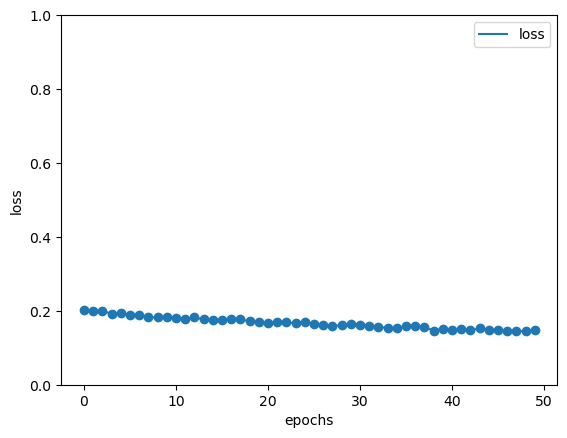

In [10]:
with open(os.path.join("saves_GRU","hist","11-06-21-50epochs-2times.json"), 'r') as f:
    hist = json.load(f)

    plt.plot(range(len(hist['loss'])), hist['loss'])
    plt.scatter(range(len(hist['loss'])), hist['loss'])
    plt.xlabel("epochs")
    plt.ylabel("loss")
    plt.legend(["loss"])
    plt.ylim((0,1))
    plt.show()

In [ ]:
# print(os.listdir(os.path.join(preprocess.getoutputdir(),str(15))))

In [ ]:
# model.metrics_names